In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import *

## Score constituencies

In [3]:
ge10, ge15, ge17 = read_in_election_results() 

In [4]:
diff_17 = score_campaigns_difference(ge17, ge15)
uns_17 = score_campaigns_uns(ge17, ge15)
mrp_17 = score_campaigns_mrp(ge17)

In [5]:
# this dataframe is just for reference
scores = pd.concat( [ge17['Constituency'],diff_17['change'],uns_17['difference'],mrp_17['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','diff','uns','mrp']
scores.sort_values('diff',ascending=False).head(10)

,Constituency,diff,uns,mrp
E14000602,Bristol West,24313.0,0.204728,0.091326
E14000755,Hove,14860.0,0.120485,0.107399
E14001061,York Central,14382.0,0.129699,0.019635
E14000562,"Birmingham, Hall Green",13996.0,0.079684,0.086971
E14000789,"Lewisham, Deptford",13889.0,0.069995,0.097449
E14001003,Truro and Falmouth,13517.0,0.126961,0.041560
E14000721,Hackney South and Shoreditch,13341.0,0.052593,0.192414
E14000601,Bristol South,13161.0,0.119037,0.057677
E14000599,Bristol East,12699.0,0.116533,0.055236
E14000619,Canterbury,12452.0,0.106817,0.002211


In [6]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,ge17)

## Select demographic data to compare constituencies

In [7]:
census = read_in_census()
print(len(census))
# only want rows we have election data for
census = census.loc[ge17.index]
print(len(census))

650
631


In [8]:
features = ['c11PopulationDensity',
                'c11HouseOwned',
                'c11CarsNone',
                'c11EthnicityWhite',
                 'c11Unemployed',
                 'c11Retired',
                 'c11FulltimeStudent',
                 'c11Age65to74',
                 'c11DeprivedNone']

In [9]:
demographic_data = census[features]
print(len(demographic_data))
demographic_data = demographic_data.dropna()
print(len(demographic_data))

631
572


In [10]:
# a list of constituencies we have complete data for
constits_id = demographic_data.index
constits_name = [name_from_onsid(i,ge17) for i in constits_id]

## Calculate confidence that a local campaign was succesful

All constituencies are compared with each other.

We calculate the 'distance' between each constituency base on their demographics. Similar constituencies, based on the features chosen above' will have a small distance between them.

We then calculate the relative score between each campaign.

This score is divided by the distance for each constituency. Our confidence in this constituencies campaing is the sum of this value for all other constituencies.

If constituency A scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one.

In [11]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

def calc_campaign_conf(demographic_data, constit_score):
    X_scaled = preprocessing.scale(demographic_data)
    dist_matrix = pairwise_distances(X_scaled)
    
    constit_score = preprocessing.scale(constit_score)
    score_matrix = constit_score[:,np.newaxis] - constit_score
    significance = np.divide(score_matrix, dist_matrix, where=dist_matrix!=0)
    return np.sum(significance,1)   

In [12]:
diff = calc_campaign_conf(demographic_data, diff_17.loc[constits_id]['change'])
uns = calc_campaign_conf(demographic_data, uns_17.loc[constits_id]['difference'])
mrp = calc_campaign_conf(demographic_data, mrp_17.loc[constits_id]['difference'])

In [13]:
results = pd.DataFrame({'constituency': constits_name,
                        'diff': uns, 'uns': diff, 'mrp': mrp},
                       index = constits_id)
results.head(10)

,constituency,diff,uns,mrp
ons_id,,,,
E14000530,Aldershot,163.274203,76.598684,48.252000
E14000531,Aldridge-Brownhills,-132.050079,-231.928558,-40.878108
E14000532,Altrincham and Sale West,134.316126,100.034591,156.341001
E14000533,Amber Valley,-437.824784,-454.447566,-254.522746
E14000534,Arundel and South Downs,95.796978,131.742643,2.454435
E14000535,Ashfield,-535.182481,-391.796382,-87.664545
E14000536,Ashford,102.515766,153.173727,265.157255
E14000537,Ashton-under-Lyne,31.065113,-109.073055,415.559946
E14000538,Aylesbury,273.379619,286.217141,197.978652


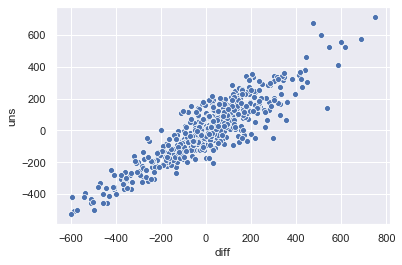

In [14]:
sns.scatterplot(x=results['diff'], y=results['uns'])

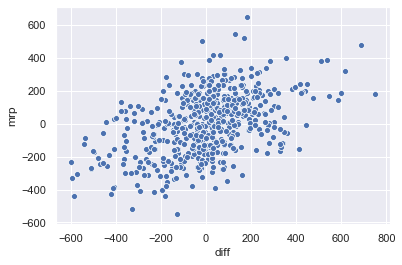

In [15]:
sns.scatterplot(x=results['diff'], y=results['mrp'])

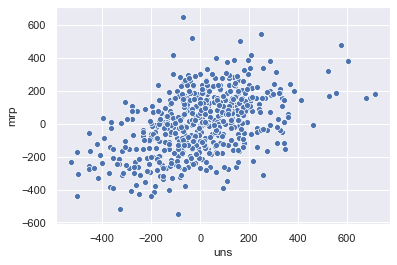

In [16]:
sns.scatterplot(x=results['uns'], y=results['mrp'])

In [17]:
results.sort_values('mrp',ascending=False)

,constituency,diff,uns,mrp
ons_id,,,,
W07000070,Cynon Valley,183.786757,-69.706369,647.688433
E14000688,Ellesmere Port and Neston,129.799878,249.678802,545.390179
E14000661,Denton and Reddish,169.621623,-31.421400,520.396593
E14000581,Bootle,-16.107400,163.067179,500.621670
E14000682,East Worthing and Shoreham,686.856829,576.775204,473.362494
E14001010,Wallasey,61.653767,206.185863,415.911352
E14000537,Ashton-under-Lyne,31.065113,-109.073055,415.559946
W07000055,Newport East,356.861939,63.572172,395.101286
E14000725,Halton,13.770217,194.104649,386.726908


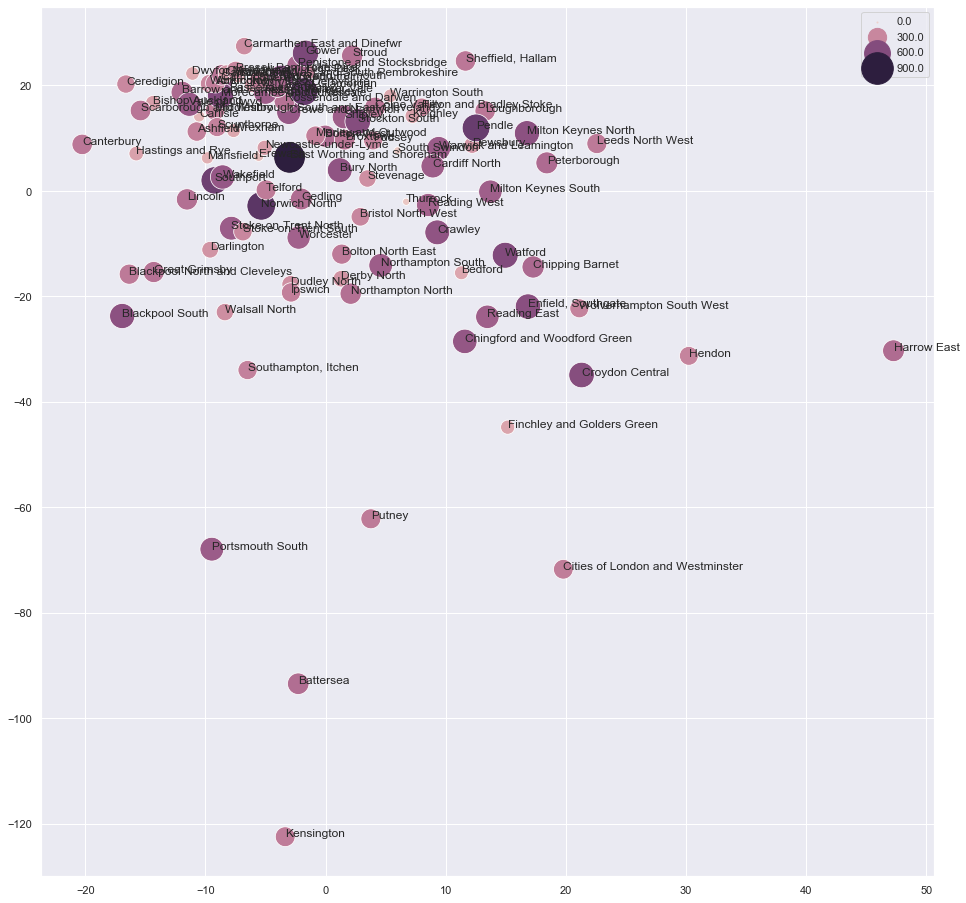

In [20]:
X = demographic_data.loc[marginals]
sizes = results['mrp'].loc[marginals]

#X = demographic_data
#sizes = results['mrp']

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

#embedding = LocallyLinearEmbedding(n_components=2)
embedding = Isomap(n_components=2)
#embedding = SpectralEmbedding(n_components=2)
embedding = MDS(n_components=2)

X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])
val = pd.Series([name_from_onsid(i,ge17) for i in X.index])
val.index=range(len(X_transformed))

sizes = np.array(sizes) - min(sizes)

plt.figure(figsize=(16, 16))
ax = sns.scatterplot(x=x,y=y,
                     size=sizes, sizes=(1, 1000),
                     hue=sizes)
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x']+.001, point['y'], str(point['val']))


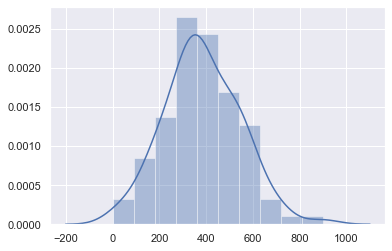

In [19]:
sns.distplot(sizes)